In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import differential_evolution
from numba import jit
from scipy import stats
from sklearn.linear_model import LinearRegression


"""
class data: processing factor data
please assure that your factor data has same time horizon and time step
"""


class data:
    def __init__(self,path):
        self.path=path
        self.df=pd.read_csv(path).iloc[:,-1]
        self.zfactor=self.process()
        
    def process(self):
        #fill NA and z_score
        newdf=self.df.fillna(self.df.mean())
        newdf=stats.zscore(newdf)
        return newdf
# read in factors
VIX=data("/home/niyu/Documents/Project/GA/VIX.csv")
YIELD=data("/home/niyu/Documents/Project/GA/Yield.csv")
LIQ=data("/home/niyu/Documents/Project/GA/LIQ.csv")
SZ=data("/home/niyu/Documents/Project/GA/logSZ.csv")
RM=data("/home/niyu/Documents/Project/GA/RM.csv")
y=pd.read_csv("/home/niyu/Documents/Project/GA/r.csv",index_col=0) #whole y of SP100

print("All data sets loaded:VIX,Yield,LIQ,logSZ,RM,return")


All data sets loaded:VIX,Yield,LIQ,logSZ,RM,return


In [2]:
class factor:
    """
    A list of factor exposure
    """
    def __init__(self,factor_list):
        self.num=len(factor_list)
        self.factors=factor_list
        self.cov=self.analysis()
        
    
    def u(self):
        """
        get factor mean value
        """
        factor_mean=[np.mean(i.zfactor) for i in self.factors]
        return np.array(factor_mean)
        
    def analysis(self):
        """
        input: list of factor as Series object
        return: the cov of your factors
        """
        factor_array=[np.array(i.zfactor) for i in self.factors]
        covariance=np.cov(factor_array)
        return covariance
    
    
    def Cholesky(self):
        """
        generate multivariate normal simulation
        """
        A=np.linalg.cholesky(self.cov)
        return A
            
    
    def simulation(self,N):
        """
        Simulate multivariate normal
        N: number of trails
        """
        self.mean=self.u()
        self.simulation=np.random.multivariate_normal(self.mean,self.cov,N)
        return self.simulation
    
    
#factor preprocess
factor_list=[VIX,YIELD,LIQ,SZ,RM]

factor_z_score=[i.zfactor for i in factor_list]
x=np.array(factor_z_score).T

expected_return=np.mean(y) #whole return of SP100
y=np.array(y)
y=np.nan_to_num(y) #fill nan return with 0


print('factor list: VIX,Yield,LIQ,SZ,RM')
print('expected return of SP100:',expected_return)



factor list: VIX,Yield,LIQ,SZ,RM
expected return of SP100: 0     0.000834
1     0.000715
2     0.000395
3     0.000730
4     0.001020
5     0.000993
6     0.000833
7     0.000863
8     0.000737
9     0.001139
10    0.000395
11    0.000695
12    0.001098
13    0.000728
14    0.000743
15    0.000880
16    0.000700
17    0.000527
18    0.000125
19    0.000967
20    0.001286
21    0.000407
22    0.000965
23    0.000618
24    0.000065
25    0.000632
26    0.000497
27    0.000575
28    0.000201
29    0.000925
        ...   
70    0.000712
71    0.001671
72    0.000365
73   -0.000073
74    0.000477
75    0.000451
76    0.000309
77    0.000301
78    0.000192
79    0.000231
80    0.000963
81    0.000806
82    0.000229
83    0.000260
84    0.000426
85    0.000475
86    0.000385
87    0.000824
88    0.000969
89    0.000641
90    0.000460
91    0.000589
92    0.000400
93    0.000973
94    0.000416
95    0.000820
96    0.000639
97    0.000211
98    0.000157
99    0.000601
Length: 100, dtype: float6

In [3]:
class portfolio:
    """
    Generate your portfolio with n stocks, if no list passed, it will randomly choose n stocks in SP100
    """
    def __init__(self,x,y,n,start,end,Num_list=None):
        
        self.x=x
        self.y=y
        self.n=n
        self.start=start
        self.end=end
        if Num_list==None:
            Num_list=np.random.randint(0,99,n) 
            
        self.Num_list=Num_list
        
        self.choose_x=self.construct()[0]
        self.choose_y=self.construct()[1]
    
    def construct(self):
        choose_x=self.x[self.start:self.end]
        choose_y=self.y[self.start:self.end,self.Num_list]
    
        return [choose_x,choose_y]

#construct portfolio with desired portfolio size n from SP100
n=15 #size of portfolio
port=portfolio(x,y,n,0,1005,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])

print("Now randomly building a portfolio with size ",n)


Now randomly building a portfolio with size  15


In [4]:
class regression:
    """
    class of regression; will give you the coeffcients of different stock against the factors
    """
    def __init__(self,portfolio,N):
        """
        y: matrix of stock return,dimesion of (n X date);n is the number of stock, date is the number of observations
        x: columns of array of factor exposures; dimension of (k X date),k is the number of factors
        n: number of stock in the portfolio
        """
        
        self.y=portfolio.choose_y
        self.x=portfolio.choose_x
        self.n=portfolio.n
        self.coef=self.regress()[0]
        self.residuals=self.regress()[1]
        self.simulated_residual=self.residual_simulation(N)
        
    def regress(self):
        

        regressor = LinearRegression()  
        regressor.fit(self.x,self.y)
        beta=regressor.coef_
        intercept=regressor.intercept_
            
        #get residulas
        y_hat=regressor.predict(self.x)
        residuals=self.y-y_hat
        
        intercept=intercept.reshape(self.n,1)
        # return the coef of dimension of (n X k), factor loading
        return [np.hstack((intercept,beta)),residuals]
    
    def residual_simulation(self,N):
        """
        get residual variance and simulate iid residual with N trials
        PS: residuals of every stock are iid normally distributed with mean 0 and specific variance 
        """
        
        #get the mean and variance of every stock residuals
        residuals_mean=np.array([0]*self.n)
        residuals_var=np.var(self.residuals,axis=0)
        residuals_cov=np.diag(residuals_var)
        
        #simulate residuals with N trials of n stocks
        #result matrix should be (Nxn)
        residuals_simulation=np.random.multivariate_normal(residuals_mean,residuals_cov,N)
        
        
        return residuals_simulation
    

In [6]:
@jit
def VaR(w,portfolio,factor_list,N):
    """
    w: column vector,weights of portfolio
    coef: an (k+1)xn array of coefficients of n stocks against the k factors,including intercepts
    factor_list: list of factors which will be used for simulation; input eg:[VIX,EIRX,VOL]
    N: trials of simulation
    """
    
    #normalize your weights for sum of 1
    w= [float(i)/sum(w) for i in w]
    all_factor=factor(factor_list)
    regressor=regression(portfolio,N)
    
    
    #assign the coef and simulated residuals
    coef=regressor.coef
    matrix_residuals=regressor.simulated_residual.T
    
    #simulate multivariate normal distribution of these factors
    #the multivariate_normal should be a 2_D array of kxN, k is the number of factors
    multivariate_normal=(all_factor.simulation(N)).T
    #print(multivariate_normal)
    
    #portfolio return= intercept+ beta*factor+error
    #assumption: iid error,will be simulated from iid normal
    #directly generate N trials in the matrix
    matrix_intercept=np.array([coef[:,0]]*N).T
    matrix_beta=coef[:,1:]
    
    stock_return=matrix_intercept+np.dot(matrix_beta,multivariate_normal)+matrix_residuals
    
    matrix_w=np.array([w]*N).T
    portfolio_return=np.multiply(matrix_w,stock_return)
    
    #sum of every stock return to get portfolio return simulation
    sum_return=np.sum(portfolio_return,axis=0)
    sort_return=np.sort(sum_return)
    #print(sort_return)
    
    #plt.plot(np.arange(0,N,1),sum_return)
    #cutoff point:
    cutoff=int(N*0.05)
    #use cutoff point's return as the VaR
    var=sort_return[cutoff]
    #print("VaR:",abs(var))
    return abs(var)


def target(w,portfolio,factor_list,N,expected_return,a):
    """
    w: column vector,weights of portfolio
    portfolio: portfolio object
    factor_list: list of factors which will be used for simulation; input eg:[VIX,EIRX,VOL]
    N: trials of simulation
    expected_return: one-column array of expected return of portfolio stocks' return,fields: stock Tickder & expected return
    a: penalty coefficient
    """
    x=portfolio.choose_x
    y=portfolio.choose_y
    expected_return=expected_return[portfolio.Num_list]
    
    #portfolio expected return
    w=np.array( [float(i)/sum(w) for i in w])
    rp=np.dot(w,expected_return)
    var=VaR(w,portfolio,factor_list,N)
    #print("portfolio expected return: ",rp,"  VaR:",var)
    return var-a*rp


In [7]:
#parameters declare
N=1000 #number of simulation trials
a=0.5 #risk aversion
bound=[(0,1)]*n  #weights bound of each asset
w=np.random.normal(size=n) #initial uns

#genetic algorithm
size,crossover,mutation=20,0.8,0.05

generation_list=[1,5,10,25,50,100,200,300,400]
w_list=[0]*9
value_list=[0]*9

print("Defined a GA model with population size of ",size," ,crossover rate of ",crossover," ,mutation parameter of ",mutation)
print("Doing multiple iteration choices:", generation_list)

In [8]:
# GA algorithm updation:
for j in range(len(generation_list)):
    generation=generation_list[j]
    optima=differential_evolution(target, bounds=bound, args=(port,factor_list,N,expected_return,a), strategy='best1bin', maxiter=generation,popsize=size,tol=0.01, mutation=mutation, recombination=crossover,seed=None, callback=None, disp=False, polish=True, init='latinhypercube')
    best_w=optima.x
    value=optima.fun
    port_w=[float(i)/sum(best_w) for i in best_w]
    
    print(generation_list[j],"iteration for VaR: ",value)
    
    w_list[j]=port_w
    value_list[j]=value
    


1 iteration for VaR:  0.012557982316339849
5 iteration for VaR:  0.01169351175203511
10 iteration for VaR:  0.012073148092893005
25 iteration for VaR:  0.011820231632740819
50 iteration for VaR:  0.011490382075194868
100 iteration for VaR:  0.011577683139348384
200 iteration for VaR:  0.011597021901103115
300 iteration for VaR:  0.011176326803201854
400 iteration for VaR:  0.01148193417795454


Text(0, 0.5, 'minima')

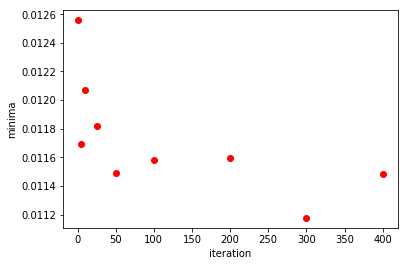

In [9]:
plt.plot(generation_list,value_list,'ro')
plt.xlabel("iteration")
plt.ylabel("minima")